# Denoising with a CNN Autoencoder

In this project we will introduce noise to the Fashion MNIST dataset and train an autoencoder to reconstruct the original input images

### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### Prepare the Dataset

Instead of just normalizing the images, we will also introduce random noise and the generated images will be used as input to your model. The target or label will still be the clean images.

In [10]:
def map_images(images, labels):
    images = tf.cast(images, tf.float32)
    images = images / 255.0
    
    noise_factor = 0.5
    factor = noise_factor * tf.random.normal(shape=images.shape)
    noisy_image = images + factor
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image, images

In [11]:
BUFFER_SIZE = 1024
BATCH_SIZE = 128

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split='train')
train_dataset = train_dataset.map(map_images)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_images)
test_dataset = test_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).repeat()

### Build the Model

We will use the simple CNN based Auto-Encoder Network as the dataset is not that much complex!

<img src="images/architecture_cnn_auto_encoder.png" width="100%" height="75%"/>

In [12]:
def encoder(inputs):
    
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    
    return max_pool_2

In [13]:
def bottle_neck(inputs):
    
    bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)
    
    return bottle_neck, encoder_visualization

In [14]:
def decoder(inputs):
    
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)
    
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid')(up_sample_2)
    
    return conv_3

In [15]:
def convolutional_auto_encoder():
    
    inputs = tf.keras.layers.Input(shape=(28,28,1,))
    
    encoder_output = encoder(inputs=inputs)
    bottle_necks, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottle_necks)
    
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    
    return model, encoder_model

### Compile and Train the Model

In [16]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=4)

Epoch 1/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 143s 271ms/step - loss: 0.3559 - val_loss: 0.3001
Epoch 2/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 125s 267ms/step - loss: 0.2966 - val_loss: 0.2939
Epoch 3/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 128s 274ms/step - loss: 0.2911 - val_loss: 0.2912
Epoch 4/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 132s 282ms/step - loss: 0.2884 - val_loss: 0.2882


### Display sample results

Although we have trained the model just for 4 epochs, training it for longer epochs may results in better denoising! However, let's see if the model can generate the clean image from noisy inputs.

In [18]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28,28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


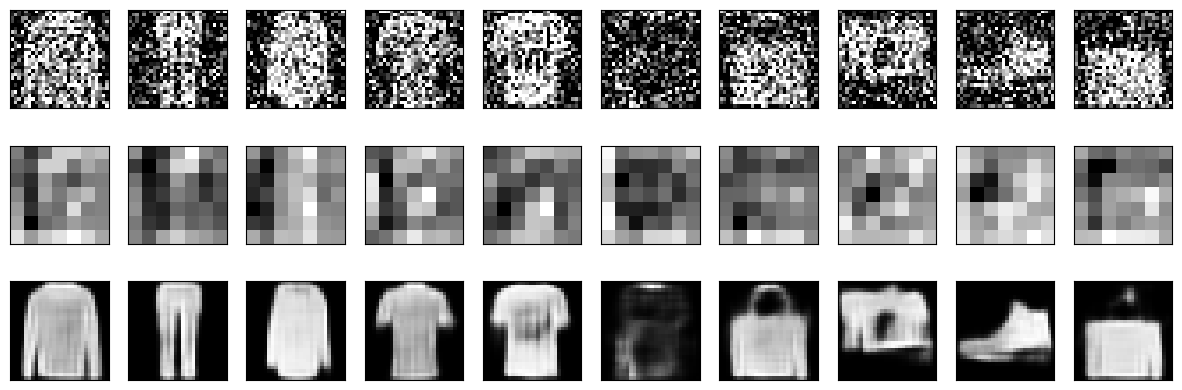

In [19]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))